# REINFORCE

In [5]:
import torch
import gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
%matplotlib inline

# avoid the gym warning message
gym.logger.set_level(40)

env = gym.make('MountainCar-v0')
env = env.unwrapped
# env.seed(1)

np.random.seed(1)
torch.manual_seed(1)

state_space = env.observation_space.shape[0]
action_space = env.action_space.n
eps = np.finfo(np.float32).eps.item()


class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size =24, learning_rate = 0.01): 
        super (PolicyNetwork, self).__init__()
        
        self.fc1 = nn.Linear(num_inputs, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = F.softmax(self.fc2(x), dim=1)
        return x
        
    def choose_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        act_probs = self.forward(state)
        c = Categorical(act_probs)
        action = c.sample()
        return action.item(), c.log_prob(action)
    
    def update_policy(self, vts, log_probs): 
        policy_loss = []
        for log_prob, vt in zip (log_probs, vts):
            policy_loss.append (-log_prob * vt)
            
        self.optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()
        
    def discounted_norm_rewards (self, rewards, GAMMA):
        vt = np.zeros_like(rewards)
        running_add = 0
        for t in reversed (range(len(rewards))):
            running_add = running_add * GAMMA + rewards[t]
            vt[t] = running_add
            
        #normalized discounted rewards
        vt = (vt - np.mean(vt)) / (np.std(vt)+eps)
        return vt


policy_net = PolicyNetwork(state_space,action_space)


def main (episodes = 5000, GAMMA = 0.99):
    all_rewards = []
    running_rewards = []
    for episode in range(episodes): 
        state, _ = env.reset(seed = 1)  # 修改这里，只获取状态部分
        rewards = []
        log_probs = []
        i = 0
        while True:
            i += 1
            action, log_prob = policy_net.choose_action(state)
            new_state, reward, done, _, info = env.step(action)  # 修改这里，获取新的状态和额外信息
            rewards.append(reward)
            log_probs.append(log_prob)

            if done: 
                vt = policy_net.discounted_norm_rewards(rewards, GAMMA)
                policy_net.update_policy(vt, log_probs)
                all_rewards.append(np.sum(rewards))
                running_rewards.append(np.mean(all_rewards[-30:]))
                print("episode={},循环{}次时的状态:{}".format(episode,i, state))
                break
            state = new_state
        print('episode:', episode, 'total reward: ', all_rewards[-1], 'running reward:', int(running_rewards[-1]))  
    return all_rewards, running_rewards, vt

all_rewards, running_rewards, vt = main(episodes = 100)
# 下面将神经网络保存
torch.save(policy_net,"../model/policyNet.pkl")

episode=0,循环4007次时的状态:[0.49952316 0.00112423]
episode: 0 total reward:  -4007.0 running reward: -4007
episode=1,循环19666次时的状态:[0.48239505 0.02402666]
episode: 1 total reward:  -19666.0 running reward: -11836
episode=2,循环19075次时的状态:[0.4914213  0.01423118]
episode: 2 total reward:  -19075.0 running reward: -14249
episode=3,循环12584次时的状态:[0.49600106 0.01532296]
episode: 3 total reward:  -12584.0 running reward: -13833
episode=4,循环8535次时的状态:[0.49978745 0.02030001]
episode: 4 total reward:  -8535.0 running reward: -12773
episode=5,循环2356次时的状态:[0.49000385 0.02179063]
episode: 5 total reward:  -2356.0 running reward: -11037
episode=6,循环12106次时的状态:[0.49533936 0.00824823]
episode: 6 total reward:  -12106.0 running reward: -11189
episode=7,循环4453次时的状态:[0.4810068  0.02125693]
episode: 7 total reward:  -4453.0 running reward: -10347
episode=8,循环6882次时的状态:[0.4985375  0.01957693]
episode: 8 total reward:  -6882.0 running reward: -9962
episode=9,循环4093次时的状态:[0.49851337 0.00459417]
episode: 9 total rewa

episode=79,循环2016次时的状态:[0.48801512 0.02057757]
episode: 79 total reward:  -2016.0 running reward: -3641
episode=80,循环2982次时的状态:[0.4923438 0.0344163]
episode: 80 total reward:  -2982.0 running reward: -3629
episode=81,循环2011次时的状态:[0.4943215  0.02074706]
episode: 81 total reward:  -2011.0 running reward: -3452
episode=82,循环3051次时的状态:[0.4856533  0.01533277]
episode: 82 total reward:  -3051.0 running reward: -3420
episode=83,循环10717次时的状态:[0.48363355 0.02443119]
episode: 83 total reward:  -10717.0 running reward: -3634
episode=84,循环3667次时的状态:[0.4995325  0.00998505]
episode: 84 total reward:  -3667.0 running reward: -3664
episode=85,循环5433次时的状态:[0.49573624 0.01871851]
episode: 85 total reward:  -5433.0 running reward: -3763
episode=86,循环1255次时的状态:[0.4775815  0.02495724]
episode: 86 total reward:  -1255.0 running reward: -3732
episode=87,循环4078次时的状态:[0.49340865 0.00885726]
episode: 87 total reward:  -4078.0 running reward: -3740
episode=88,循环4493次时的状态:[0.49111015 0.02036311]
episode: 88 total

### Plot the total rewards for all episodes

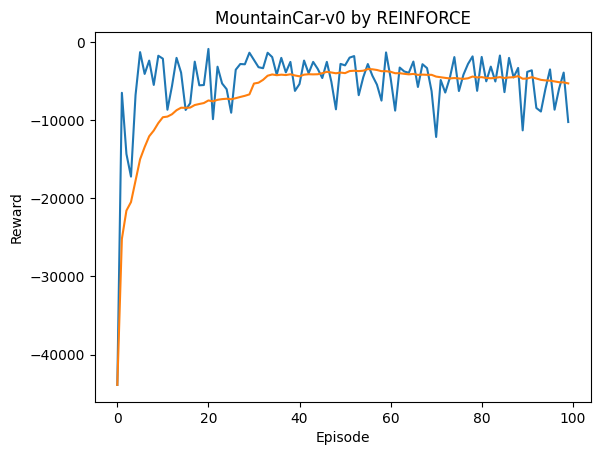

In [2]:
plt.plot(all_rewards)       
plt.plot(running_rewards)
plt.title('MountainCar-v0 by REINFORCE')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.savefig(f"15.9.jpg", dpi=600)
plt.show()

### Plot the $v_t$ in the last episode. 

$v_t$ here refers to the __normalised discounted returns__ received by the agent after taking action $a$ in state $s$ in an episode, which is used to evaluate the intensity of inducing the gradient. 

We can see that the values at the last steps are much higher than it was at the beginning, which means that it affects the $policy\_loss.append (-log\_prob * vt)$ a lot at the last steps. This makes sense that we should emphasize the steps that the car drives up to the mountain, since we always get the -1 reward except for the car reaches the top. 

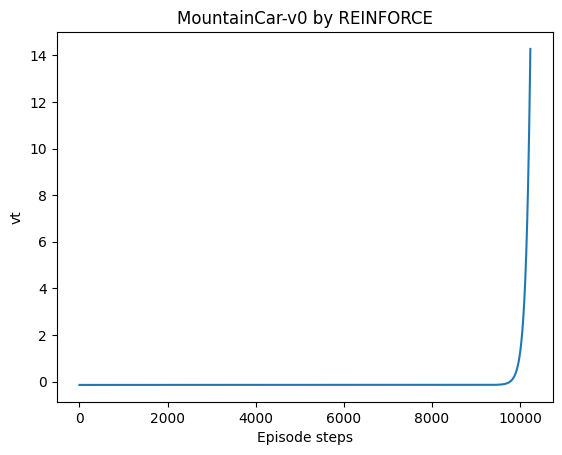

In [3]:
plt.plot(vt)
plt.title('MountainCar-v0 by REINFORCE')
plt.xlabel('Episode steps')
plt.ylabel('vt')
plt.savefig(f"15.10.jpg", dpi=600)
plt.show()

### Run your well-trained REINFORCE agent!

In [4]:
env = gym.make('MountainCar-v0')

state,_ = env.reset()  # 只取state部分
for t in range(10000):
    action, _ = policy_net.choose_action(state)
    env.render()
    state, reward, done, _, info = env.step(action)
    if done:
        break 
        
env.close()